<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [36]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [29]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

In [11]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'pAttach'],
      dtype='object')

In [34]:
df_final_train.head(10)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pAttach,svd_U,svd_V
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,120,1.114958e-11,2.238775e-12
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,8662,3.192812e-03,9.068719e-04
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,902,1.787503e-35,2.467873e-36
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,35,4.710376e-20,3.159386e-18
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,33,7.773952e-14,0.000000e+00
5,1377733,375423,1,0,0.125000,0.148148,0.223607,9,10,8,...,8.468577e-16,-3.034187e-13,8.154763e-12,4.915173e-13,3.509642e-13,2.726584e-13,2.407333e-16,80,2.634968e-23,1.106211e-22
6,1691962,1039906,1,0,0.000000,0.000000,0.000000,5,1,4,...,5.257603e-20,-1.134555e-13,5.258108e-15,1.030865e-07,5.761211e-15,1.513797e-14,4.159309e-16,4,-4.197845e-28,2.228717e-18
7,628080,812266,1,0,0.000000,0.117851,0.000000,3,7,7,...,8.853974e-14,-1.497446e-12,5.091851e-15,2.288960e-12,7.654502e-15,1.454794e-13,8.222904e-17,49,6.368162e-21,7.341618e-21
8,1725153,1822102,1,0,0.000000,0.000000,0.000000,13,9,9,...,4.071085e-17,-3.994068e-13,2.433104e-13,5.703881e-13,1.782188e-11,1.800730e-13,3.318246e-15,81,8.808941e-24,3.258620e-24
9,654494,1487831,1,0,0.111111,0.188982,0.218218,2,7,3,...,2.789305e-14,-5.228629e-15,2.701351e-15,1.020694e-07,5.219083e-15,4.038258e-14,2.350714e-16,21,5.429964e-13,7.847658e-13


In [6]:
df_final_train.shape

(100002, 54)

In [20]:
def pref_attachment(a,b):
    try:
        pAttach = len(set(train_graph.successors(a))) * len(set(train_graph.successors(b)))
        return pAttach
    except:
        return 0

# Adding Preferential Attachment to both Train and Test set

In [30]:
df_final_train['pAttach'] = df_final_train.apply(lambda row:pref_attachment(row['source_node'],row['destination_node']),axis=1)
df_final_test['pAttach'] = df_final_test.apply(lambda row:pref_attachment(row['source_node'],row['destination_node']),axis=1)

# Adding SVD U and SVD V for both Train and Test set

In [33]:
#SVD_U and SVD_V for train set
df_final_train['svd_U'] = ((df_final_train['svd_u_s_1']*df_final_train['svd_u_d_1']) + \
                            (df_final_train['svd_u_s_2']*df_final_train['svd_u_d_2']) + \
                            (df_final_train['svd_u_s_3']*df_final_train['svd_u_d_3']) + \
                            (df_final_train['svd_u_s_4']*df_final_train['svd_u_d_4']) + \
                            (df_final_train['svd_u_s_5']*df_final_train['svd_u_d_5']) + \
                            (df_final_train['svd_u_s_6']*df_final_train['svd_u_d_6']))

df_final_train['svd_V'] = ((df_final_train['svd_v_s_1']*df_final_train['svd_v_d_1']) + \
                            (df_final_train['svd_v_s_2']*df_final_train['svd_v_d_2']) + \
                            (df_final_train['svd_v_s_3']*df_final_train['svd_v_d_3']) + \
                            (df_final_train['svd_v_s_4']*df_final_train['svd_v_d_4']) + \
                            (df_final_train['svd_v_s_5']*df_final_train['svd_v_d_5']) + \
                            (df_final_train['svd_v_s_6']*df_final_train['svd_v_d_6']))

#SVD_U and SVD_V for test set
df_final_test['svd_U'] = ((df_final_test['svd_u_s_1']*df_final_test['svd_u_d_1']) + \
                            (df_final_test['svd_u_s_2']*df_final_test['svd_u_d_2']) + \
                            (df_final_test['svd_u_s_3']*df_final_test['svd_u_d_3']) + \
                            (df_final_test['svd_u_s_4']*df_final_test['svd_u_d_4']) + \
                            (df_final_test['svd_u_s_5']*df_final_test['svd_u_d_5']) + \
                            (df_final_test['svd_u_s_6']*df_final_test['svd_u_d_6']))

df_final_test['svd_V'] = ((df_final_test['svd_v_s_1']*df_final_test['svd_v_d_1']) + \
                            (df_final_test['svd_v_s_2']*df_final_test['svd_v_d_2']) + \
                            (df_final_test['svd_v_s_3']*df_final_test['svd_v_d_3']) + \
                            (df_final_test['svd_v_s_4']*df_final_test['svd_v_d_4']) + \
                            (df_final_test['svd_v_s_5']*df_final_test['svd_v_d_5']) + \
                            (df_final_test['svd_v_s_6']*df_final_test['svd_v_d_6']))

In [38]:
#class labels
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [39]:
#Dropping source node, destination node and Class label

df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9063252121775113 test Score 0.8745605278006858
Estimators =  50 Train Score 0.9205725512208812 test Score 0.9125653355634538
Estimators =  100 Train Score 0.9238690848446947 test Score 0.9141199714153599
Estimators =  250 Train Score 0.9239789348046863 test Score 0.9188007232664732
Estimators =  450 Train Score 0.9237190618658074 test Score 0.9161507685828595
--- 32.99197602272034 seconds ---
Wall time: 33 s


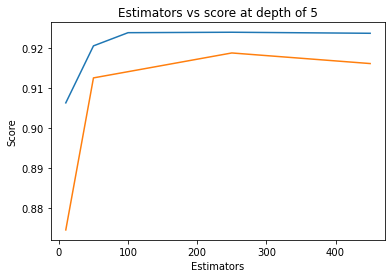

In [9]:
%%time
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')


depth =  3 Train Score 0.8916120853581238 test Score 0.8687934859875491
depth =  9 Train Score 0.9572226298198419 test Score 0.9222953031452904
depth =  11 Train Score 0.9623451340902863 test Score 0.9252318758281279
depth =  15 Train Score 0.9634267621927706 test Score 0.9231288356496615
depth =  20 Train Score 0.9631629153051491 test Score 0.9235051024711141
depth =  35 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  50 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  70 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  130 Train Score 0.9634333127085721 test Score 0.9235601652753184


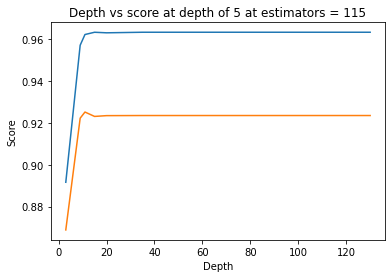

Wall time: 58.8 s


In [11]:
%%time
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [12]:
%%time
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96225042 0.96215492 0.9605708  0.96194014 0.96330005]
mean train scores [0.96294922 0.96266735 0.96115674 0.96263457 0.96430539]
Wall time: 5min 38s


In [ ]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [ ]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9652533106548414
Test f1 score 0.9241678239279553


In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


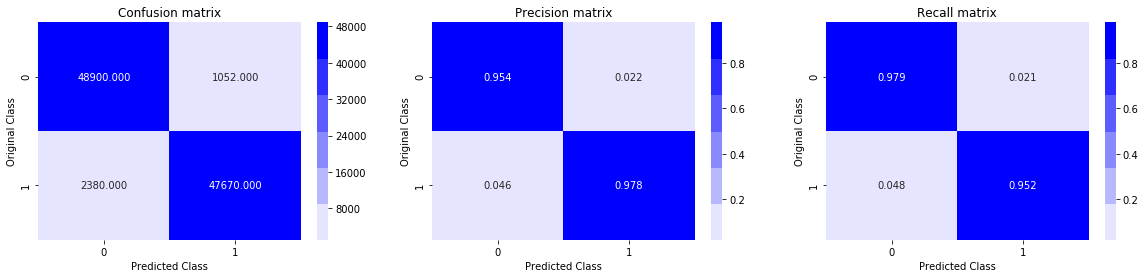

Test confusion_matrix


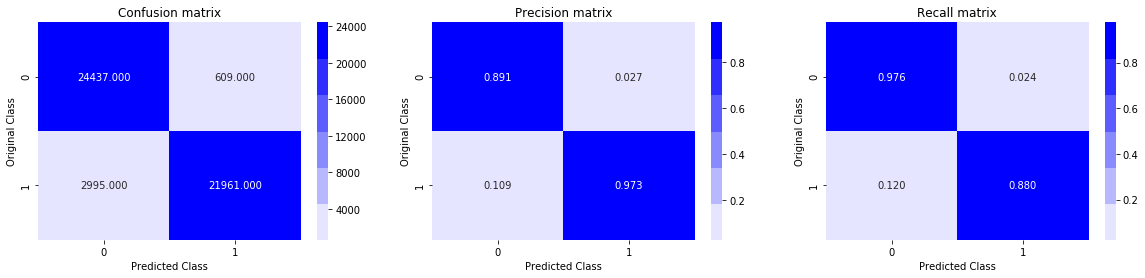

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

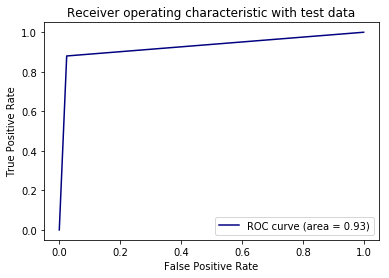

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

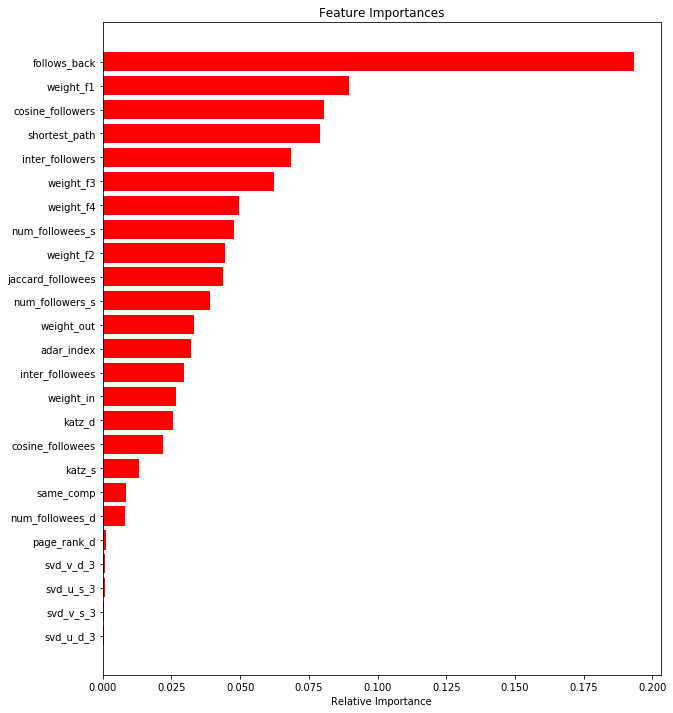

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

# Tuning hyperparameters for XGBoost

Estimators =  10 Train Score 0.9276333993146456 test Score 0.9268803418803419
Estimators =  50 Train Score 0.962612041091966 test Score 0.9291335251311559
Estimators =  100 Train Score 0.9719061238564677 test Score 0.931377308707124
Estimators =  200 Train Score 0.9764863005382655 test Score 0.9296186440677965
Estimators =  250 Train Score 0.9785466708434807 test Score 0.9292736672599374
Estimators =  450 Train Score 0.9840812751089945 test Score 0.927158789166224
Estimators =  1000 Train Score 0.9949319925482262 test Score 0.9209350071643961
CPU times: user 29min 15s, sys: 228 ms, total: 29min 15s
Wall time: 3min 40s


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

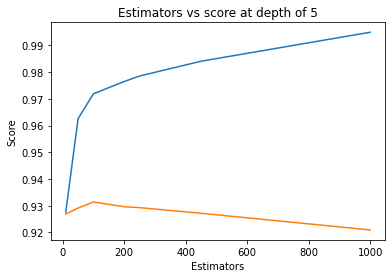

In [47]:
%%time

#Best hyperparameter taking 5 DEPTH --- 100 ESTIMATORS
estimators = [10,50,100,200,250,450,1000]
train_scores = []
test_scores = []
for i in estimators:
    clf = XGBClassifier(n_estimators=i, learning_rate=0.05, colsample_bytree=1, max_depth=5)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9653424185273063 test Score 0.9229144221222298
depth =  9 Train Score 0.9791607713142256 test Score 0.9291438748250858
depth =  11 Train Score 0.9847760772689693 test Score 0.9284775511934541
depth =  15 Train Score 0.9964322937545097 test Score 0.9288088232181038
depth =  20 Train Score 0.999880129460183 test Score 0.9301902748414376
depth =  35 Train Score 0.9998901219646193 test Score 0.932897924786685
depth =  50 Train Score 0.9998901219646193 test Score 0.9329764363697678
depth =  70 Train Score 0.9998901219646193 test Score 0.9329764363697678
depth =  130 Train Score 0.9998901219646193 test Score 0.9329764363697678


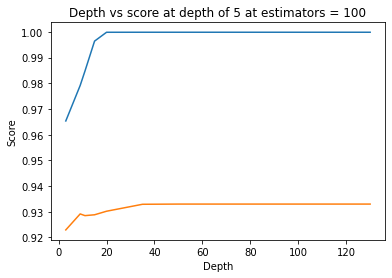

CPU times: user 27min 35s, sys: 420 ms, total: 27min 35s
Wall time: 3min 30s


In [49]:
%%time

#Best hyperparameter taking 100 estimators --- 50 DEPTH
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = XGBClassifier(max_depth=i, learning_rate=0.05, colsample_bytree=1, n_estimators=100)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 100')
plt.show()

In [51]:
%%time
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(20,35),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = XGBClassifier(random_state=25)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1',random_state=25,return_train_score=True,verbose = 10,n_jobs=-1)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed: 17.2min remaining: 111.8min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed: 17.7min remaining: 48.8min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed: 18.0min remaining: 27.0min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 18.5min remaining: 16.2min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 33.3min remaining: 16.7min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 33.7min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 34.3min finished


mean test scores [0.98031757 0.98029506 0.97987795 0.9798943  0.98036728]
mean train scores [1. 1. 1. 1. 1.]
CPU times: user 3min 48s, sys: 652 ms, total: 3min 49s
Wall time: 34min 48s


In [52]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=24,
              min_child_weight=1, min_samples_leaf=28, min_samples_split=111,
              missing=nan, monotone_constraints='()', n_estimators=121,
              n_jobs=8, num_parallel_tree=1, random_state=25, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [54]:
#Best Params
# n_estimators - 121
# max_depth - 24
# min_samples_split - 111
# min_samples_leaf - 28

clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=24,
              min_child_weight=1, min_samples_leaf=28, min_samples_split=111,
              monotone_constraints='()', n_estimators=121,
              n_jobs=8, num_parallel_tree=1, random_state=25, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
#Fitting to best model
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [56]:
#Getting F1 scores of train and test

from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.9292535733192164


In [57]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


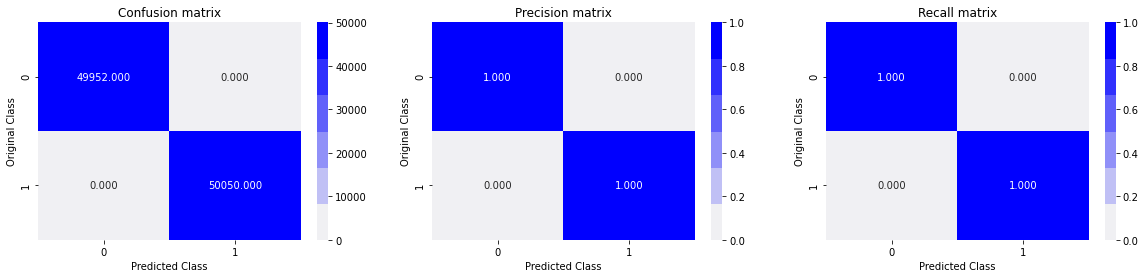

Test confusion_matrix


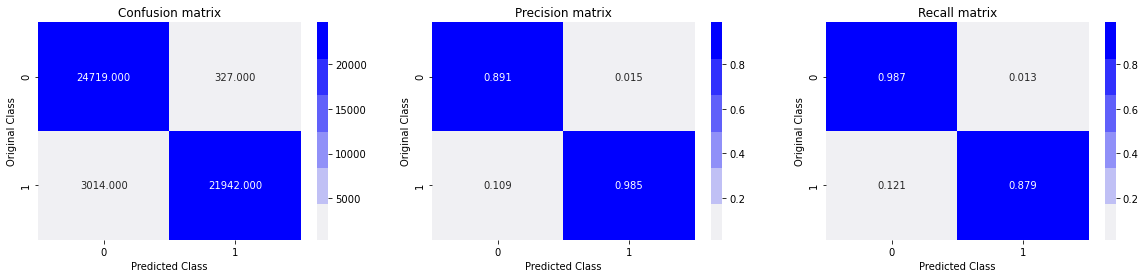

In [58]:
#Plotting confusion matrix
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

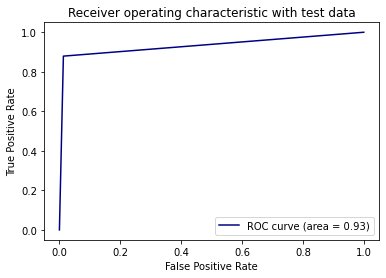

In [59]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

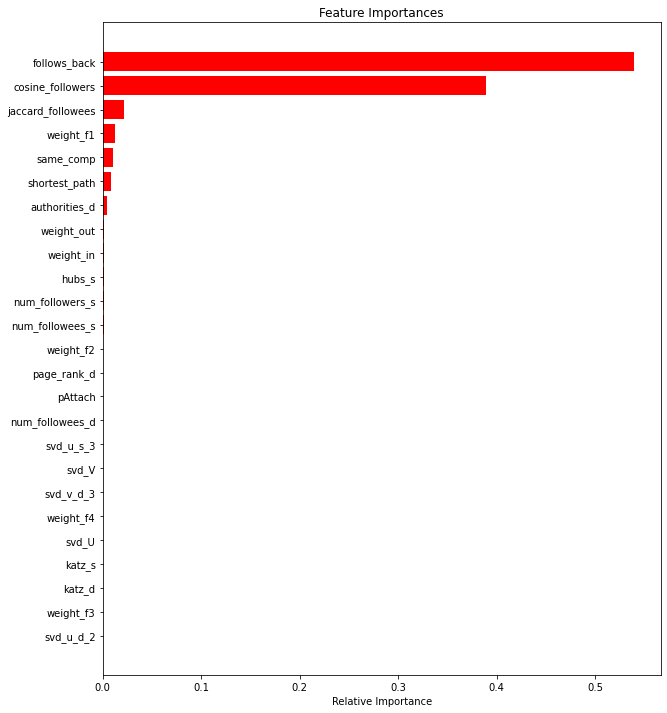

In [60]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

 Preferential attachment is comparitively higher on feature importance scale than SVD U and SVD V features.

 Performance of model has marginally improved.